#Import & Setup & Load

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
import scipy.sparse
import joblib
import os
import time
from tqdm.notebook import tqdm

# Scikit-learn for model training and data splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Imbalanced-learn for handling imbalanced datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

# ### 1.2 NLTK Downloads
# We need to download specific NLTK resources for text processing (stopwords, tokenizers, and lemmatizer).

nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK resources downloaded.")

All libraries imported successfully!
NLTK resources downloaded.


In [2]:
#Dataset
df = pd.read_csv("../fake_job_postings.csv")

#Data Preparation

##Check Missing Value

In [3]:
print("Total Missing Values: ")
df.isnull().sum()

Total Missing Values: 


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [4]:
print("Missing Percent (%): ")
df.isnull().sum().sort_values(ascending=False) / len(df.index)*100

Missing Percent (%): 


salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
location                1.935123
description             0.005593
title                   0.000000
job_id                  0.000000
telecommuting           0.000000
has_questions           0.000000
has_company_logo        0.000000
fraudulent              0.000000
dtype: float64

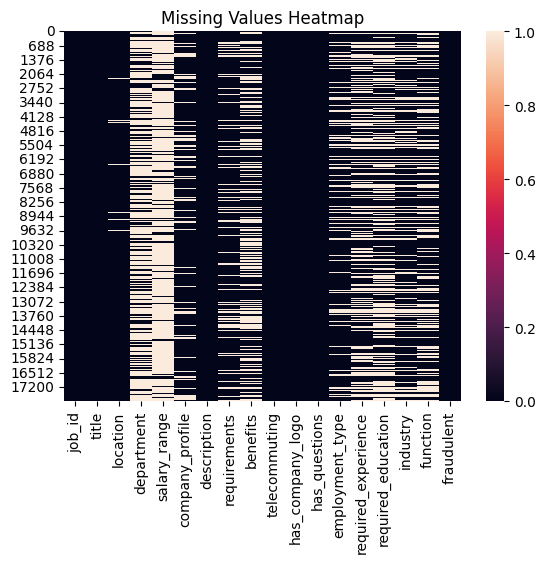

In [5]:
# view missing value
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=True)
plt.title("Missing Values Heatmap")
plt.show()

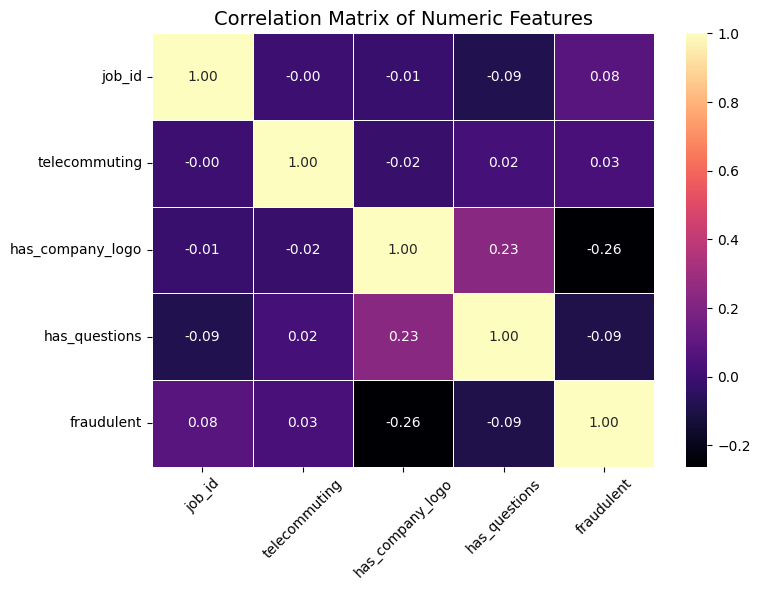

In [6]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Data Transformation

Format and Standard the keyword

"High school or equivalent" and "Some high school coursework" → both can be grouped as High School.

For entries containing "degree" (e.g., Bachelor’s Degree, Associate Degree, Vocational Degree), you can group them under their main level (Bachelor, Associate, Vocational, etc.).

In [7]:
def map_education_level(education):
    if pd.isna(education): return 'Unknown'
    level_map = {
        "Bachelor's Degree": 'Bachelor',
        'High School or equivalent': 'High School',
        'Unspecified': 'Unknown',
        "Master's Degree": 'Master',
        'Associate Degree': 'Associate',
        'Certification': 'Certification',
        'Some College Coursework Completed': 'Some College',
        'Professional': 'Professional',
        'Vocational': 'Vocational',
        'Some High School Coursework': 'High School',
        'Doctorate': 'Doctorate',
        'Vocational - HS Diploma': 'High School',
        'Vocational - Degree': 'Associate'
    }
    return level_map.get(education, 'Other')

print("`map_education_level` function defined.")

`map_education_level` function defined.


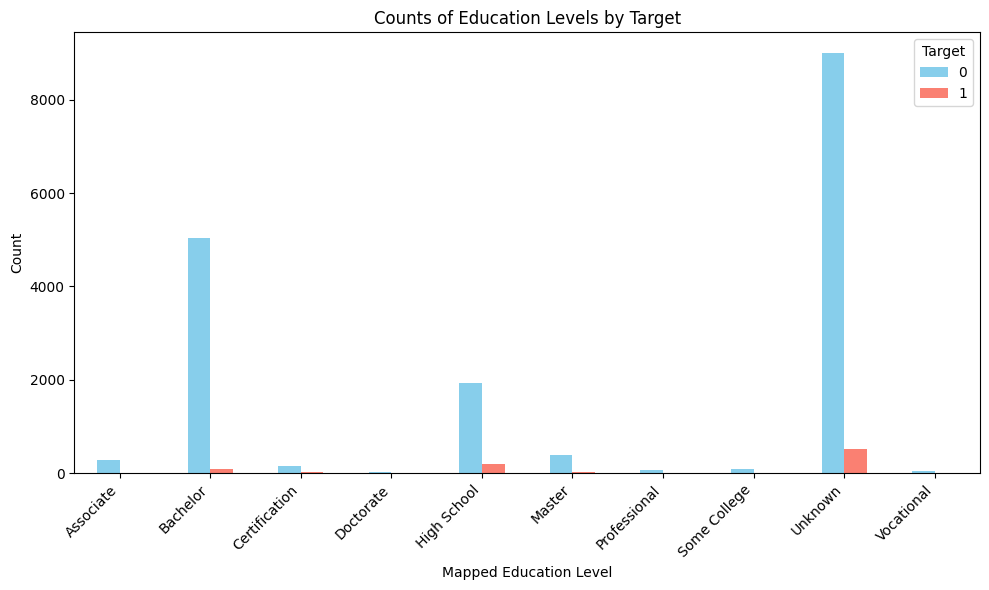

In [8]:
import matplotlib.pyplot as plt

# Group by mapped education level on the fly and target
education_target_counts = df.groupby([df['required_education'].apply(map_education_level), 'fraudulent']).size().unstack(fill_value=0)

# Plot stacked bar chart
education_target_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['skyblue', 'salmon']
)

plt.xlabel('Mapped Education Level')
plt.ylabel('Count')
plt.title('Counts of Education Levels by Target')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Target')
plt.tight_layout()
plt.show()


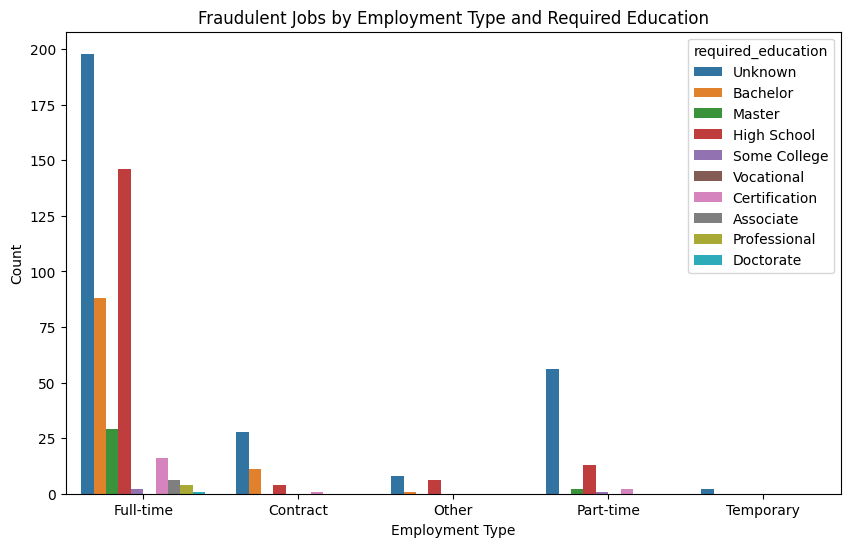

In [9]:
plt.figure(figsize=(10,6))

sns.countplot(
    x="employment_type", 
    hue=df['required_education'].apply(map_education_level),   # temporary mapping here
    data=df[df['fraudulent']==1]
)

plt.title("Fraudulent Jobs by Employment Type and Required Education")
plt.xlabel("Employment Type")
plt.ylabel("Count")
plt.show()


In [10]:
def map_industry(industry):
    if pd.isna(industry): return 'Unknown'
    level_map = {
        "Marketing and Advertising":"Marketing", "Computer Software":"Technology",
        "Hospital & Health Care":"Healthcare", "Online Media":"Media",
        "Information Technology and Services":"Technology", "Financial Services":"Finance",
        "Management Consulting":"Consulting", "Events Services":"Events",
        "Internet":"Technology", "Facilities Services":"Services",
        "Consumer Electronics":"Consumer Goods", "Telecommunications":"Telecommunications",
        "Consumer Services":"Services", "Construction":"Construction",
        "Oil & Energy":"Energy", "Education Management":"Education",
        "Building Materials":"Construction Materials", "Banking":"Finance",
        "Food & Beverages":"Food", "Food Production":"Food",
        "Health, Wellness and Fitness":"Health", "Insurance":"Finance",
        "E-Learning":"Education", "Cosmetics":"Beauty",
        "Staffing and Recruiting":"Services", "Venture Capital & Private Equity":"Finance",
        "Leisure, Travel & Tourism":"Travel", "Human Resources":"HR",
        "Pharmaceuticals":"Medical", "Farming":"Agriculture",
        "Legal Services":"Law", "Luxury Goods & Jewelry":"Luxury",
        "Machinery":"Manufacturing", "Real Estate":"Property",
        "Mechanical or Industrial Engineering":"Engineering",
        "Public Relations and Communications":"PR", "Consumer Goods":"Consumer Products",
        "Medical Practice":"Medical", "Electrical/Electronic Manufacturing":"Manufacturing",
        "Hospitality":"Services", "Music":"Entertainment",
        "Market Research":"Research", "Automotive":"Automotive",
        "Philanthropy":"Charity", "Utilities":"Services",
        "Primary/Secondary Education":"Education", "Logistics and Supply Chain":"Logistics",
        "Design":"Design", "Gambling & Casinos":"Entertainment",
        "Accounting":"Finance", "Environmental Services":"Environment",
        "Mental Health Care":"Medical", "Investment Management":"Finance",
        "Apparel & Fashion":"Fashion", "Media Production":"Media",
        "Publishing":"Media", "Medical Devices":"Medical",
        "Information Services":"Information", "Retail":"Retail",
        "Sports":"Sports", "Computer Games":"Entertainment",
        "Chemicals":"Chemistry", "Aviation & Aerospace":"Aerospace",
        "Business Supplies and Equipment":"Business", "Program Development":"Development",
        "Computer Networking":"Technology", "Biotechnology":"Biotech",
        "Civic & Social Organization":"Social", "Religious Institutions":"Religion",
        "Warehousing":"Logistics", "Airlines/Aviation":"Aviation",
        "Writing and Editing":"Writing", "Restaurants":"Food",
        "Outsourcing/Offshoring":"Services", "Transportation/Trucking/Railroad":"Transport",
        "Wireless":"Telecommunications", "Investment Banking":"Finance",
        "Nonprofit Organization Management":"Nonprofit", "Libraries":"Education",
        "Computer Hardware":"Technology", "Broadcast Media":"Media",
        "Printing":"Printing", "Graphic Design":"Design",
        "Entertainment":"Entertainment", "Wholesale":"Retail",
        "Research":"Research", "Animation":"Entertainment",
        "Government Administration":"Government", "Capital Markets":"Finance",
        "Computer & Network Security":"Technology", "Semiconductors":"Technology",
        "Security and Investigations":"Security", "Architecture & Planning":"Architecture",
        "Maritime":"Maritime", "Fund-Raising":"Charity",
        "Higher Education":"Education", "Renewables & Environment":"Environment",
        "Motion Pictures and Film":"Entertainment", "Law Practice":"Law",
        "Government Relations":"Government", "Packaging and Containers":"Packaging",
        "Sporting Goods":"Sports", "Mining & Metals":"Mining",
        "Import and Export":"Trade", "International Trade and Development":"Trade",
        "Professional Training & Coaching":"Training", "Textiles":"Textile",
        "Commercial Real Estate":"Property", "Law Enforcement":"Law",
        "Package/Freight Delivery":"Delivery", "Translation and Localization":"Language",
        "Photography":"Photography", "Industrial Automation":"Automation",
        "Wine and Spirits":"Beverage", "Public Safety":"Safety",
        "Civil Engineering":"Engineering", "Military":"Defense",
        "Defense & Space":"Defense", "Veterinary":"Animal",
        "Executive Office":"Management", "Performing Arts":"Arts",
        "Individual & Family Services":"Social", "Public Policy":"Government",
        "Nanotechnology":"Science", "Museums and Institutions":"Culture",
        "Fishery":"Agriculture", "Plastics":"Chemistry",
        "Furniture":"Household", "Shipbuilding":"Maritime",
        "Alternative Dispute Resolution":"Legal", "Ranching":"Agriculture"
    }
    return level_map.get(industry, 'Other')

print("`map_industry` function defined.")

`map_industry` function defined.


In [11]:
print("Missing in original industry:", df['industry'].isna().sum())

#temparily check the mapping function
print("Missing in mapped industry:", df['industry'].apply(map_industry).isna().sum()) 

Missing in original industry: 4903
Missing in mapped industry: 0


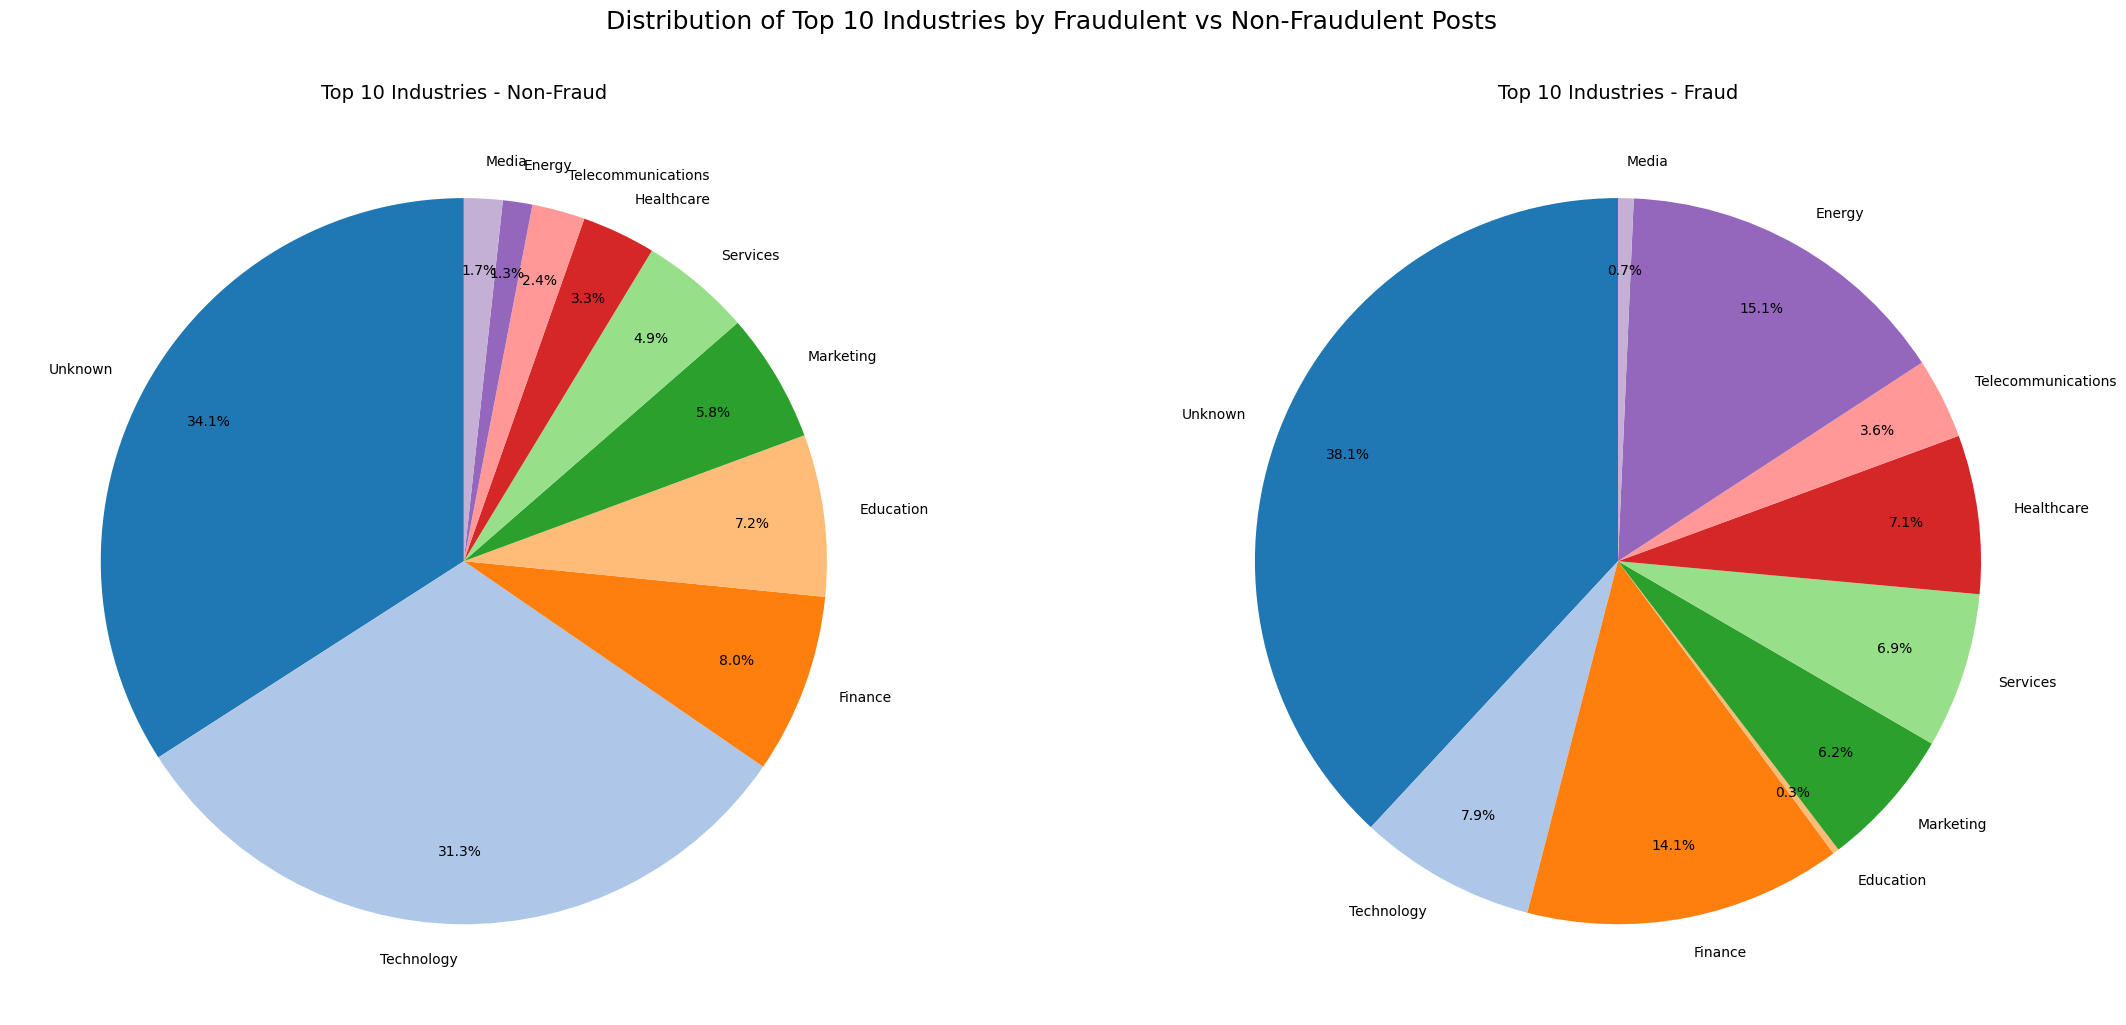

In [12]:
industry_target_counts = df.groupby(df['industry'].apply(map_industry))['fraudulent'].value_counts().unstack(fill_value=0)

#top10
industry_target_counts['total'] = industry_target_counts.sum(axis=1)
top10 = industry_target_counts.sort_values('total', ascending=False).head(10)
top10 = top10.drop(columns='total')

fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # wider, less tall

# Non-Fraud
axes[0].pie(
    top10[0],
    labels=top10.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab20.colors,
    pctdistance=0.8,     # push % closer to edge
    labeldistance=1.1    # push labels further out
)
axes[0].set_title('Top 10 Industries - Non-Fraud', fontsize=14)

# Fraud
axes[1].pie(
    top10[1],
    labels=top10.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab20.colors,
    pctdistance=0.8,
    labeldistance=1.1
)
axes[1].set_title('Top 10 Industries - Fraud', fontsize=14)

plt.suptitle('Distribution of Top 10 Industries by Fraudulent vs Non-Fraudulent Posts', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


By this comparing pie chart 
FRAUD ==> the 'Unknown' that missing value have 38.1% and second is technology, third is energy
NON FRAUD ==> related technology almost is non fraud


##Drop Column
1. Job id - this is Unique ID
2. salary range - missing 80% value - Too much missing data
3. Telecommuniting - no relation since the correlation matrix only 0.02-0.03 that almost 0

In [13]:
#Drop columns that unused

cols_to_drop = ['job_id','telecommuting','salary_range']
df.drop(columns=cols_to_drop, inplace=True)

Check has_company_logo (-0.26) and has_question (-0.09) still have more weak relationship with target 

p < 0.05 → the column is significantly related to the target. then keep it to train

p ≥ 0.05 → the column is not significantly related, can consider dropping.

In [14]:
from scipy.stats import chi2_contingency

binary_columns = ['has_questions', 'has_company_logo']
target = 'fraudulent'

for col in binary_columns:
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"{col} -> p-value: {p}")
    if p < 0.05:
        print(f"  {col} is significantly related to {target}\n")
    else:
        print(f"  {col} is NOT significantly related to {target}\n")

has_questions -> p-value: 2.515984961488263e-34
  has_questions is significantly related to fraudulent

has_company_logo -> p-value: 3.5943691337772625e-268
  has_company_logo is significantly related to fraudulent



Check again the missing percent and starting to go on filling value part 

In [15]:
print("Missing Percent (%): ")
df.isnull().sum().sort_values(ascending=False) / len(df.index)*100

Missing Percent (%): 


department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
location                1.935123
description             0.005593
title                   0.000000
has_questions           0.000000
has_company_logo        0.000000
fraudulent              0.000000
dtype: float64

##Fill Missing Values (check missing value have significant with the fraud)
(object column)

it is to create another dataframe

for check the cell of missing value have sigificant with the fraud purpose

In [16]:
import pandas as pd

# Select text columns
text_cols = df.select_dtypes(include='object').columns.tolist()

# Create a copy to keep original df intact
df_filled = df.copy()

# Fill missing and create _missing columns
for col in text_cols:
    df_filled[col + '_missing'] = df_filled[col].isnull().astype(int)
    df_filled[col] = df_filled[col].fillna('Unknown')  # Fill missing values with empty string

# Check results
df_filled[text_cols + [c + '_missing' for c in text_cols]].head()


,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,...,department_missing,company_profile_missing,description_missing,requirements_missing,benefits_missing,employment_type_missing,required_experience_missing,required_education_missing,industry_missing,function_missing
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unknown,Other,Internship,Unknown,...,0,0,0,0,1,0,0,1,1,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,Unknown,...,0,0,0,0,0,0,0,1,0,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unknown,Unknown,Unknown,Unknown,...,1,0,0,0,1,1,1,1,1,1
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,...,0,0,0,0,0,0,0,0,0,0
4,Bill Review Manager,"US, FL, Fort Worth",Unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,...,1,0,0,0,0,0,0,0,0,0


In [17]:
print("Total Missing Values: ")
df_filled.isnull().sum()

Total Missing Values: 


title                          0
location                       0
department                     0
company_profile                0
description                    0
requirements                   0
benefits                       0
has_company_logo               0
has_questions                  0
employment_type                0
required_experience            0
required_education             0
industry                       0
function                       0
fraudulent                     0
title_missing                  0
location_missing               0
department_missing             0
company_profile_missing        0
description_missing            0
requirements_missing           0
benefits_missing               0
employment_type_missing        0
required_experience_missing    0
required_education_missing     0
industry_missing               0
function_missing               0
dtype: int64

In [18]:
import pandas as pd
from scipy.stats import chi2_contingency

target = 'fraudulent'

# Find all _missing columns in df_filled
missing_cols = [c for c in df_filled.columns if c.endswith('_missing')]

significant_missing_cols = []

print("Chi-square test results for _missing columns:\n")
for col in missing_cols:
    # Use df_filled instead of df
    contingency = pd.crosstab(df_filled[col], df_filled[target])
    chi2, p, dof, ex = chi2_contingency(contingency)

    if p < 0.05:
        result = "significantly related"
        significant_missing_cols.append(col)
    else:
        result = "NOT significantly related"

    print(f"{col}: p-value = {p:.4e} → {result}")

print("\nColumns to consider keeping (_missing with signal):")
print(significant_missing_cols)


Chi-square test results for _missing columns:

title_missing: p-value = 1.0000e+00 → NOT significantly related
location_missing: p-value = 6.5960e-01 → NOT significantly related
department_missing: p-value = 4.3126e-02 → significantly related
company_profile_missing: p-value = 0.0000e+00 → significantly related
description_missing: p-value = 3.5424e-02 → significantly related
requirements_missing: p-value = 2.5651e-02 → significantly related
benefits_missing: p-value = 3.1350e-01 → NOT significantly related
employment_type_missing: p-value = 1.8267e-10 → significantly related
required_experience_missing: p-value = 3.3094e-11 → significantly related
required_education_missing: p-value = 5.0215e-05 → significantly related
industry_missing: p-value = 3.8358e-03 → significantly related
function_missing: p-value = 8.3552e-02 → NOT significantly related

Columns to consider keeping (_missing with signal):
['department_missing', 'company_profile_missing', 'description_missing', 'requirements_

The _missing columns indicate whether the original column was missing (1) or not (0).

The Chi-square test shows whether the fact that a value is missing is significantly related to the target (fraudulent).

It does not directly test the original column's content, only whether missingness itself carries predictive information.

and just provide the information adn findings

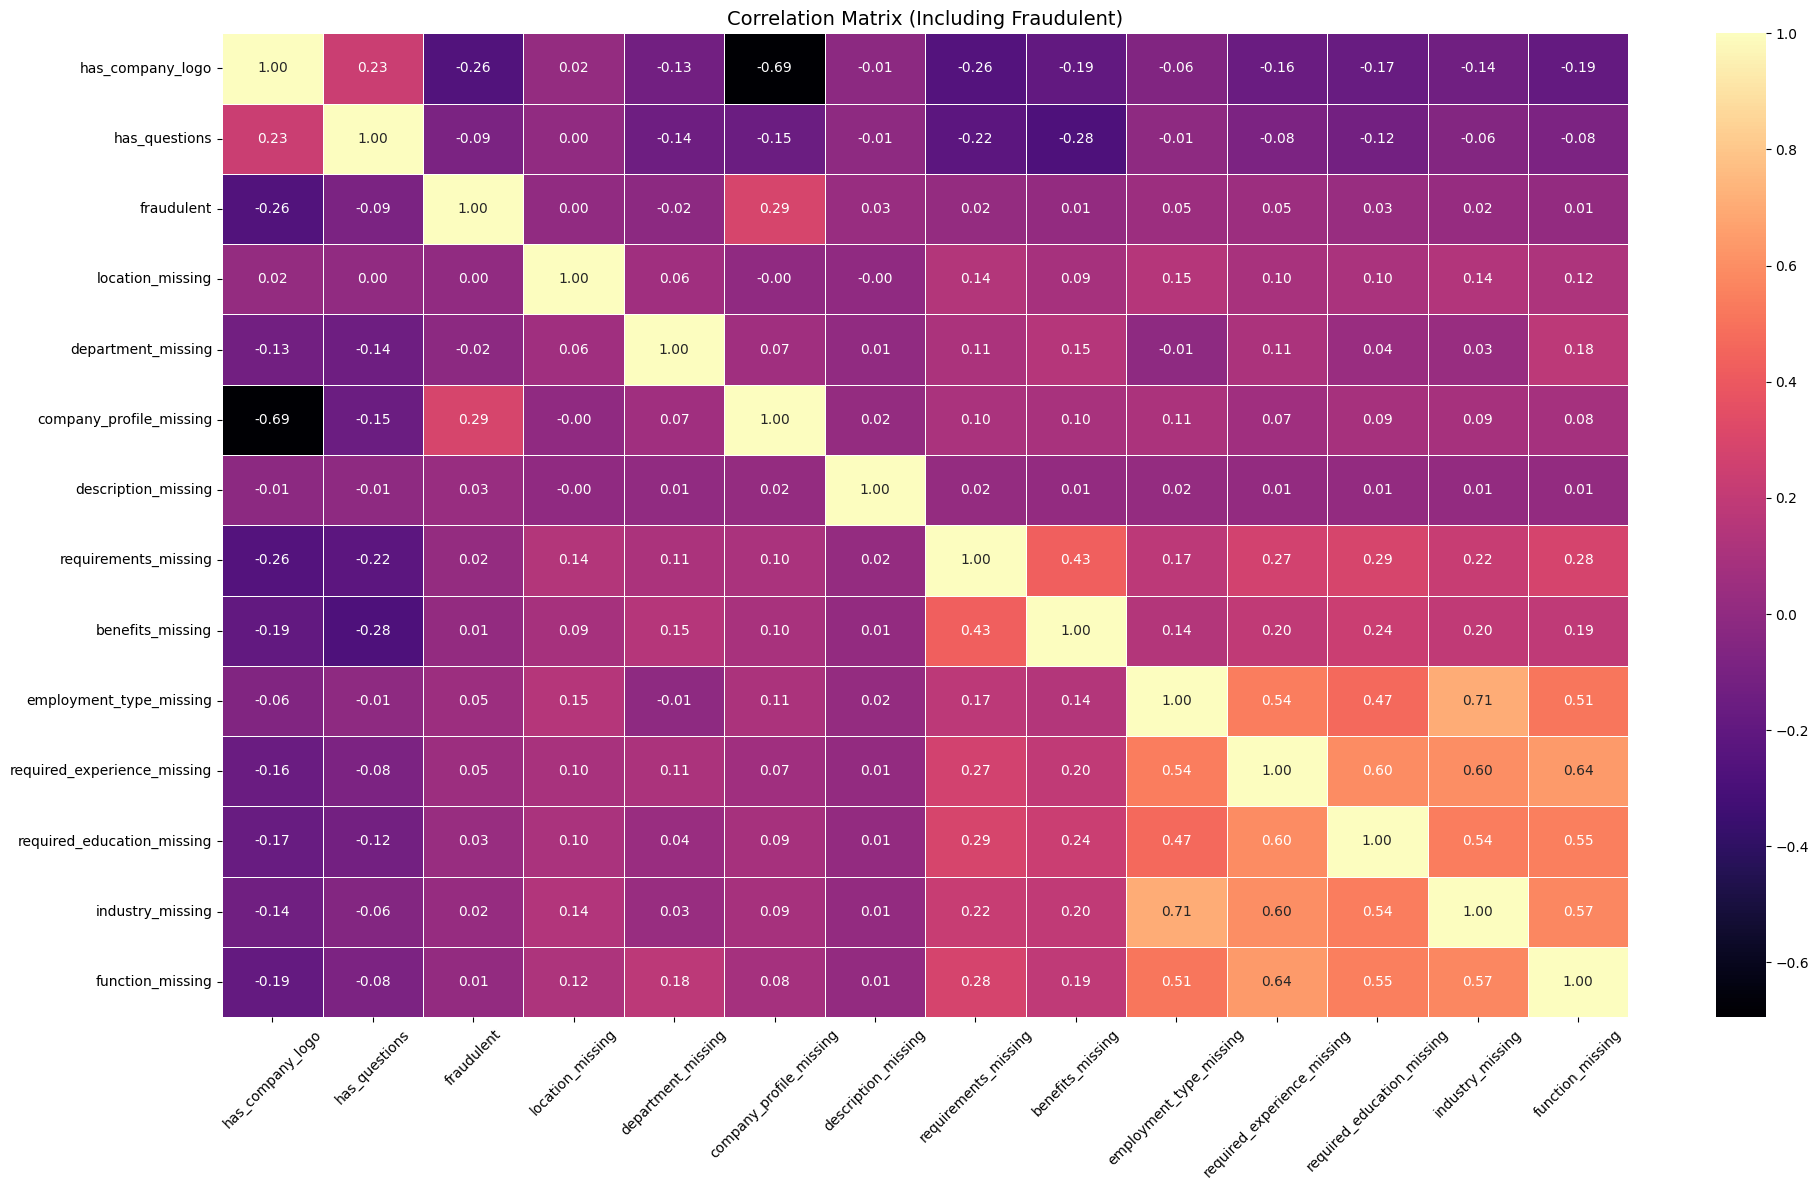

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_df = df_filled.select_dtypes(include=['int64', 'float64'])
if 'fraudulent' not in numeric_df.columns:
    raise ValueError("'fraudulent' column is missing or not numeric")

corr_matrix = numeric_df.corr()

fraud_related_cols = corr_matrix.columns[corr_matrix.loc['fraudulent'].notna()]
corr_matrix = corr_matrix.loc[fraud_related_cols, fraud_related_cols]

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

plt.title('Correlation Matrix (Including Fraudulent)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Text Processing

In [20]:
def clean_text(text):
    if pd.isna(text):
        return ""

    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")

    # 2. Remove non-ASCII characters
    text = text.encode("ascii", "ignore").decode("ascii")

    # 3. Remove URLs and emails
    url_pattern = r"https?://\S+|www\.\S+"
    email_pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    text = re.sub(url_pattern, "", text, flags=re.IGNORECASE)
    text = re.sub(email_pattern, "", text, flags=re.IGNORECASE)

    # 4. Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # 5. Tokenize & lowercase (keeping only alphabetic tokens)
    tokens = [t for t in word_tokenize(text.lower()) if t.isalpha()]

    # 6. Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stop_words]

    # 7. Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)

print("`clean_text` function defined.")

`clean_text` function defined.


In [21]:
def fill_important_columns(data):
    important_columns = [
        'department', 'company_profile', 'description',
        'requirements', 'employment_type', 'required_experience',
        'required_education', 'industry', 'benefits', 'function', 'location'
    ]
    for col in important_columns:
        if col in data.columns:
            data[col] = data[col].fillna('Unknown')
    return data

def map_categorical_fields(data):
    if 'required_education' in data.columns:
        data['required_education'] = data['required_education'].apply(map_education_level)
    if 'industry' in data.columns:
        data['industry'] = data['industry'].apply(map_industry)
    if 'location' in data.columns:
        data['location'] = data['location'].astype(str).apply(
            lambda x: x.split(',')[0].strip() if pd.notna(x) and x else 'Unknown'
        )
    return data

def convert_binary_flags(data):
    binary_columns = ['has_company_logo', 'has_questions', 'telecommuting']
    for col in binary_columns:
        if col in data.columns:
            data[col] = data[col].map({1: 'Yes', 0: 'No'}).fillna('No')
    return data

def combine_text_fields(data):
    text_cols_to_combine = [
        'title','department','location','company_profile','description',
        'requirements','benefits','employment_type',
        'required_experience','required_education',
        'industry','function'
    ]
    binary_columns = ['has_company_logo', 'has_questions', 'telecommuting']
    text_cols_to_combine.extend([col for col in binary_columns if col in data.columns])
    data['combined_text'] = data[text_cols_to_combine].astype(str).agg(' '.join, axis=1)
    return data

def clean_combined_text(data):
    tqdm.pandas(desc="Cleaning Text")
    data['cleaned_text'] = data['combined_text'].progress_apply(clean_text)
    return data


Applying the function to the dataframe

In [22]:
#check before Apply filling missing value
print("Total Missing Values: ")
df.isnull().sum()

Total Missing Values: 


title                      0
location                 346
department             11547
company_profile         3308
description                1
requirements            2696
benefits                7212
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [23]:
#make a copy data frame 
#current is 'data' instead of df
data = df.copy()

# Step 1
data = fill_important_columns(data)
display(data.head(100))

,title,location,department,company_profile,description,requirements,benefits,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unknown,1,0,Other,Internship,Unknown,Unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,1,0,Full-time,Not Applicable,Unknown,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unknown,1,0,Unknown,Unknown,Unknown,Unknown,Unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",Unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Senior Marketing Manager,"US, ,",Marketing,Industrial Color Software is a division of Ind...,Senior Marketing ManagerOur photography and vi...,"Reporting to the VP Marketing, this person wil...",Full benefits,1,0,Full-time,Director,Master's Degree,Internet,Marketing,0
96,Software Test Engineer [QA]: Cucumber / LAMP /...,"GB, , London",Unknown,At LendInvest fundamentally changing the way p...,#URL_f10cb7b12799258d60f3a0af7edf7799f96bced6f...,Responsibilities:Manual and Automation testing...,HackathonsLots of greenfield projectsOpportuni...,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Financial Services,Information Technology,0
97,Customer Service Associate,"US, PA, Pittsburgh",Unknown,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,Unknown,1,0,Full-time,Entry level,High School or equivalent,Consumer Services,Customer Service,0
98,IC&E Technician,"US, , Stocton, CA",Oil & Energy,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1


In [24]:
#check after Apply filling missing value
print("Total Missing Values: ")
data.isnull().sum()

Total Missing Values: 


title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [25]:
data = map_categorical_fields(data)
display(data[['required_education', 'industry', 'location']].head(3))

,required_education,industry,location
0,Other,Other,US
1,Other,Marketing,NZ
2,Other,Other,US


In [26]:
for col in ['required_education', 'industry', 'location']:
    print(f"Unique values in {col}:")
    uniques = sorted(data[col].dropna().unique())
    for val in uniques:
        print(" -", val)
    print("Total unique:", len(uniques))
    print("-" * 50)


Unique values in required_education:
 - Associate
 - Bachelor
 - Certification
 - Doctorate
 - High School
 - Master
 - Other
 - Professional
 - Some College
 - Unknown
 - Vocational
Total unique: 11
--------------------------------------------------
Unique values in industry:
 - Aerospace
 - Agriculture
 - Animal
 - Architecture
 - Arts
 - Automation
 - Automotive
 - Aviation
 - Beauty
 - Beverage
 - Biotech
 - Business
 - Charity
 - Chemistry
 - Construction
 - Construction Materials
 - Consulting
 - Consumer Goods
 - Consumer Products
 - Culture
 - Defense
 - Delivery
 - Design
 - Development
 - Education
 - Energy
 - Engineering
 - Entertainment
 - Environment
 - Events
 - Fashion
 - Finance
 - Food
 - Government
 - HR
 - Health
 - Healthcare
 - Household
 - Information
 - Language
 - Law
 - Legal
 - Logistics
 - Luxury
 - Management
 - Manufacturing
 - Maritime
 - Marketing
 - Media
 - Medical
 - Mining
 - Nonprofit
 - Other
 - PR
 - Packaging
 - Photography
 - Printing
 - Propert

the location is show the country code now i would like to encoding to the full text country name 

In [27]:
print("Unique locations:")
print(data['location'].unique())
print("Total unique:", data['location'].nunique())


Unique locations:
['US' 'NZ' 'DE' 'GB' 'AU' 'SG' 'IL' 'AE' 'CA' 'IN' 'EG' 'PL' 'GR'
 'Unknown' 'PK' 'BE' 'BR' 'SA' 'DK' 'RU' 'ZA' 'CY' 'HK' 'TR' 'IE' 'LT'
 'JP' 'NL' 'AT' 'KR' 'FR' 'EE' 'TH' 'PA' 'KE' 'MU' 'MX' 'RO' 'MY' 'FI'
 'CN' 'ES' 'SE' 'CL' 'UA' 'QA' 'IT' 'LV' 'IQ' 'BG' 'PH' 'CZ' 'VI' 'MT'
 'HU' 'BD' 'KW' 'LU' 'NG' 'RS' 'BY' 'VN' 'ID' 'ZM' 'NO' 'BH' 'UG' 'CH'
 'TT' 'SD' 'SK' 'AR' 'TW' 'PT' 'PE' 'CO' 'IS' 'SI' 'MA' 'AM' 'TN' 'GH'
 'AL' 'HR' 'CM' 'SV' 'NI' 'LK' 'JM' 'KZ' 'KH']
Total unique: 91


In [28]:
def map_categorical_fields(data):
    # --- location mapping ---
    country_map = {
        "AE": "United Arab Emirates",
        "AL": "Albania",
        "AM": "Armenia",
        "AR": "Argentina",
        "AT": "Austria",
        "AU": "Australia",
        "BD": "Bangladesh",
        "BE": "Belgium",
        "BG": "Bulgaria",
        "BH": "Bahrain",
        "BR": "Brazil",
        "BY": "Belarus",
        "CA": "Canada",
        "CH": "Switzerland",
        "CL": "Chile",
        "CM": "Cameroon",
        "CN": "China",
        "CO": "Colombia",
        "CY": "Cyprus",
        "CZ": "Czech Republic",
        "DE": "Germany",
        "DK": "Denmark",
        "EE": "Estonia",
        "EG": "Egypt",
        "ES": "Spain",
        "FI": "Finland",
        "FR": "France",
        "GB": "United Kingdom",
        "GH": "Ghana",
        "GR": "Greece",
        "HK": "Hong Kong",
        "HR": "Croatia",
        "HU": "Hungary",
        "ID": "Indonesia",
        "IE": "Ireland",
        "IL": "Israel",
        "IN": "India",
        "IQ": "Iraq",
        "IS": "Iceland",
        "IT": "Italy",
        "JM": "Jamaica",
        "JP": "Japan",
        "KE": "Kenya",
        "KH": "Cambodia",
        "KR": "South Korea",
        "KW": "Kuwait",
        "KZ": "Kazakhstan",
        "LK": "Sri Lanka",
        "LT": "Lithuania",
        "LU": "Luxembourg",
        "LV": "Latvia",
        "MA": "Morocco",
        "MT": "Malta",
        "MU": "Mauritius",
        "MX": "Mexico",
        "MY": "Malaysia",
        "NG": "Nigeria",
        "NI": "Nicaragua",
        "NL": "Netherlands",
        "NO": "Norway",
        "NZ": "New Zealand",
        "PA": "Panama",
        "PE": "Peru",
        "PH": "Philippines",
        "PK": "Pakistan",
        "PL": "Poland",
        "PT": "Portugal",
        "QA": "Qatar",
        "RO": "Romania",
        "RS": "Serbia",
        "RU": "Russia",
        "SA": "Saudi Arabia",
        "SD": "Sudan",
        "SE": "Sweden",
        "SG": "Singapore",
        "SI": "Slovenia",
        "SK": "Slovakia",
        "SV": "El Salvador",
        "TH": "Thailand",
        "TN": "Tunisia",
        "TR": "Turkey",
        "TT": "Trinidad and Tobago",
        "TW": "Taiwan",
        "UA": "Ukraine",
        "UG": "Uganda",
        "US": "United States",
        "Unknown": "Unknown",
        "VI": "U.S. Virgin Islands",
        "VN": "Vietnam",
        "ZA": "South Africa",
        "ZM": "Zambia"
    }

    if 'location' in data.columns:
        data['location'] = data['location'].map(country_map).fillna('Other')

    # (keep your other categorical mappings here: education, industry, etc.)
    
    return data


# --- Apply to your dataframe ---
data = map_categorical_fields(data)
display(data[['required_education', 'industry', 'location']].head(3))


,required_education,industry,location
0,Other,Other,United States
1,Other,Marketing,New Zealand
2,Other,Other,United States


In [29]:
print("Unique locations:")
print(data['location'].unique())
print("Total unique:", data['location'].nunique())


Unique locations:
['United States' 'New Zealand' 'Germany' 'United Kingdom' 'Australia'
 'Singapore' 'Israel' 'United Arab Emirates' 'Canada' 'India' 'Egypt'
 'Poland' 'Greece' 'Unknown' 'Pakistan' 'Belgium' 'Brazil' 'Saudi Arabia'
 'Denmark' 'Russia' 'South Africa' 'Cyprus' 'Hong Kong' 'Turkey' 'Ireland'
 'Lithuania' 'Japan' 'Netherlands' 'Austria' 'South Korea' 'France'
 'Estonia' 'Thailand' 'Panama' 'Kenya' 'Mauritius' 'Mexico' 'Romania'
 'Malaysia' 'Finland' 'China' 'Spain' 'Sweden' 'Chile' 'Ukraine' 'Qatar'
 'Italy' 'Latvia' 'Iraq' 'Bulgaria' 'Philippines' 'Czech Republic'
 'U.S. Virgin Islands' 'Malta' 'Hungary' 'Bangladesh' 'Kuwait'
 'Luxembourg' 'Nigeria' 'Serbia' 'Belarus' 'Vietnam' 'Indonesia' 'Zambia'
 'Norway' 'Bahrain' 'Uganda' 'Switzerland' 'Trinidad and Tobago' 'Sudan'
 'Slovakia' 'Argentina' 'Taiwan' 'Portugal' 'Peru' 'Colombia' 'Iceland'
 'Slovenia' 'Morocco' 'Armenia' 'Tunisia' 'Ghana' 'Albania' 'Croatia'
 'Cameroon' 'El Salvador' 'Nicaragua' 'Sri Lanka' 'Jamaica' 'Ka

In [30]:
# Step 3
data = convert_binary_flags(data)
display(data[['has_company_logo','has_questions']].head(6))

,has_company_logo,has_questions
0,Yes,No
1,Yes,No
2,Yes,No
3,Yes,No
4,Yes,Yes
5,No,No


In [31]:
#combine these column
#'title','department','location','company_profile','description','requirements',
# 'benefits','employment_type','required_experience','required_education','
# industry','function', has_company_logo', 'has_questions'

data = combine_text_fields(data)
print(data['combined_text'].iloc[0])
print(data['combined_text'].iloc[1])
print(data['combined_text'].iloc[2])
print(data['combined_text'].iloc[3])
print(data['combined_text'].iloc[4])

Marketing Intern Marketing United States We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community a

In [32]:
data = clean_combined_text(data)
print(data['cleaned_text'].iloc[0])


Cleaning Text:   0%|          | 0/17880 [00:00<?, ?it/s]

marketing intern marketing united state created groundbreaking cooking site support connect celebrate home cook give everything need one top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish professional like mario batali gwyneth paltrow danny meyer partnership whole food market random named best food website james beard foundation iacp featured new york time npr pando daily techcrunch today located chelsea new york city james beard online food community curated recipe hub currently interviewing unpaid intern work small team editor executive developer new york city repackaging existing content number partner site huffington post yahoo buzzfeed various content management systemsresearching blog website provision affiliate programassisting affiliate program support screening affiliate assisting affilia

In [33]:
print(data['cleaned_text'].iloc[1])
print(data['cleaned_text'].iloc[2])
print(data['cleaned_text'].iloc[3])
print(data['cleaned_text'].iloc[4])

customer service cloud video production success new zealand second world cloud video production second world cloud video production service enabling brand agency get high quality online video content shot produced anywhere world second make video production fast affordable managed seamlessly cloud purchase publish second remove hassle cost risk speed issue working regular video production company managing every aspect video project beautiful online experience growing global network rated video professional country managed dedicated production success team country second provides success second produced almost video country global brand including world largest including paypal loreal sony barclays office auckland london sydney tokyo singapore organised focused vibrant awesome passion customer service slick typing skill maybe account management think administration cooler polar bear jetski need hear cloud video production service opperating glodal level yeah pretty cool serious aboutdeli

In [34]:
def get_classifiers():
    return {
        "Random Forest": RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features="sqrt",
            class_weight="balanced", # Helps with imbalanced classes
            random_state=42,
            n_jobs=-1 # Use all available cores
        ),
        "Naive Bayes": MultinomialNB(),
        "Support Vector Machine": SVC(
            probability=True, # Required for probability predictions
            random_state=42
        )
    }
print("`get_classifiers` function defined.")

`get_classifiers` function defined.


In [35]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,combined_text,cleaned_text
0,Marketing Intern,United States,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unknown,Yes,No,Other,Internship,Other,Other,Marketing,0,Marketing Intern Marketing United States We're...,marketing intern marketing united state create...
1,Customer Service - Cloud Video Production,New Zealand,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Yes,No,Full-time,Not Applicable,Other,Marketing,Customer Service,0,Customer Service - Cloud Video Production Succ...,customer service cloud video production succes...
2,Commissioning Machinery Assistant (CMA),United States,Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unknown,Yes,No,Unknown,Unknown,Other,Other,Unknown,0,Commissioning Machinery Assistant (CMA) Unknow...,commissioning machinery assistant cma unknown ...
3,Account Executive - Washington DC,United States,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Yes,No,Full-time,Mid-Senior level,Bachelor,Technology,Sales,0,Account Executive - Washington DC Sales United...,account executive washington dc sale united st...
4,Bill Review Manager,United States,Unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Yes,Yes,Full-time,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,Bill Review Manager Unknown United States Spot...,bill review manager unknown united state spots...


In [36]:
X = data.drop(columns=['fraudulent'])
y = df['fraudulent']

In [37]:
X.head().columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'combined_text', 'cleaned_text'],
      dtype='object')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Fraudulent cases in training set: {y_train.sum()} ({y_train.mean():.2%})")
print(f"Fraudulent cases in test set: {y_test.sum()} ({y_test.mean():.2%})")

Training set size: 12516 samples
Test set size: 5364 samples
Fraudulent cases in training set: 606 (4.84%)
Fraudulent cases in test set: 260 (4.85%)


In [39]:
vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1,2), min_df=2, stop_words='english', sublinear_tf=True
)

In [40]:
X_train_vectorized = vectorizer.fit_transform(X_train['cleaned_text'])

In [41]:
print(f"TF-IDF vectorizer fitted. Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Shape of X_train after TF-IDF: {X_train_vectorized.shape}")
print("TF-IDF vectorizer is ready to transform text into numerical features.")

TF-IDF vectorizer fitted. Vocabulary size: 5000
Shape of X_train after TF-IDF: (12516, 5000)
TF-IDF vectorizer is ready to transform text into numerical features.


Top 20 TF-IDF words in training data (excluding 'unknown'):
experience     0.029458
work           0.028957
team           0.027958
service        0.025930
company        0.024927
yes            0.024715
customer       0.024449
business       0.023697
technology     0.023287
job            0.021875
client         0.021553
new            0.021155
product        0.021135
skill          0.021040
year           0.020814
development    0.020590
management     0.020028
sale           0.019922
working        0.019715
state          0.018962
dtype: float64


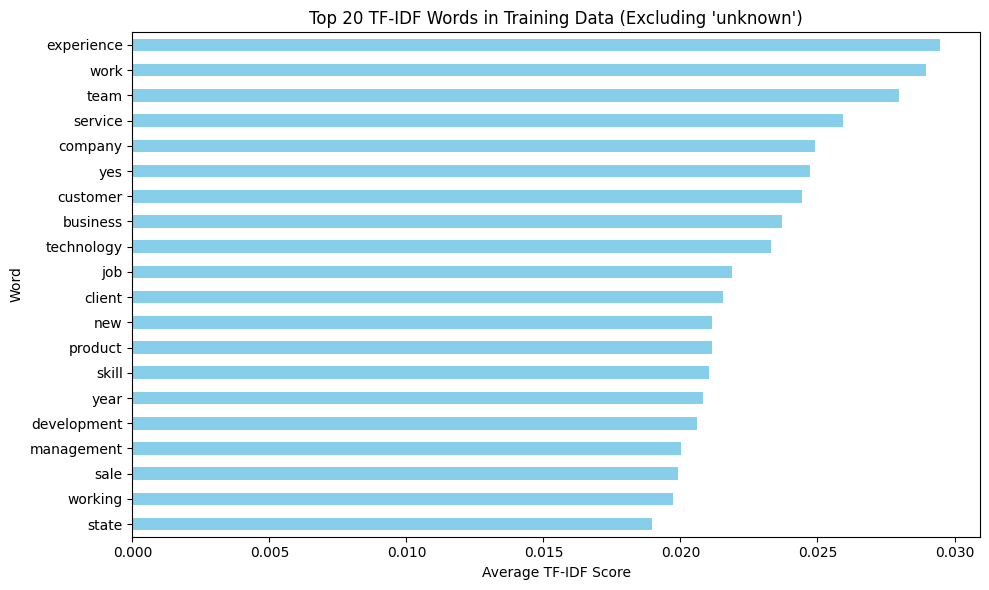

In [42]:
mean_tfidf = X_train_vectorized.mean(axis=0)
mean_tfidf = np.array(mean_tfidf).flatten()

tfidf_scores = pd.Series(mean_tfidf, index=vectorizer.get_feature_names_out())

# Remove 'unknown'
if 'unknown' in tfidf_scores.index:
    tfidf_scores = tfidf_scores.drop('unknown')
    
if 'unknown unknown' in tfidf_scores.index:
    tfidf_scores = tfidf_scores.drop('unknown unknown')

# Sort descending
tfidf_scores = tfidf_scores.sort_values(ascending=False)

print("Top 20 TF-IDF words in training data (excluding 'unknown'):")
print(tfidf_scores.head(20))

plt.figure(figsize=(10,6))
tfidf_scores.head(20).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 20 TF-IDF Words in Training Data (Excluding 'unknown')")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


Number of fraud texts: 866
Number of non-fraud texts: 17014

Top 20 TF-IDF words in FRAUDULENT job postings:
work              0.029787
experience        0.027764
service           0.027351
customer          0.026210
skill             0.025802
position          0.024193
entry             0.023062
time              0.021634
state             0.021121
company           0.021115
united            0.020850
united state      0.020434
data              0.020289
level             0.020072
team              0.020065
job               0.019971
business          0.019238
year              0.018947
home              0.018484
administrative    0.018263
dtype: float64

Top 20 TF-IDF words in NON-FRAUDULENT job postings:
experience     0.029492
work           0.028755
team           0.028283
service        0.025711
company        0.025070
yes            0.024765
customer       0.024283
business       0.023823
technology     0.023495
client         0.021896
job            0.021834
product        0.02

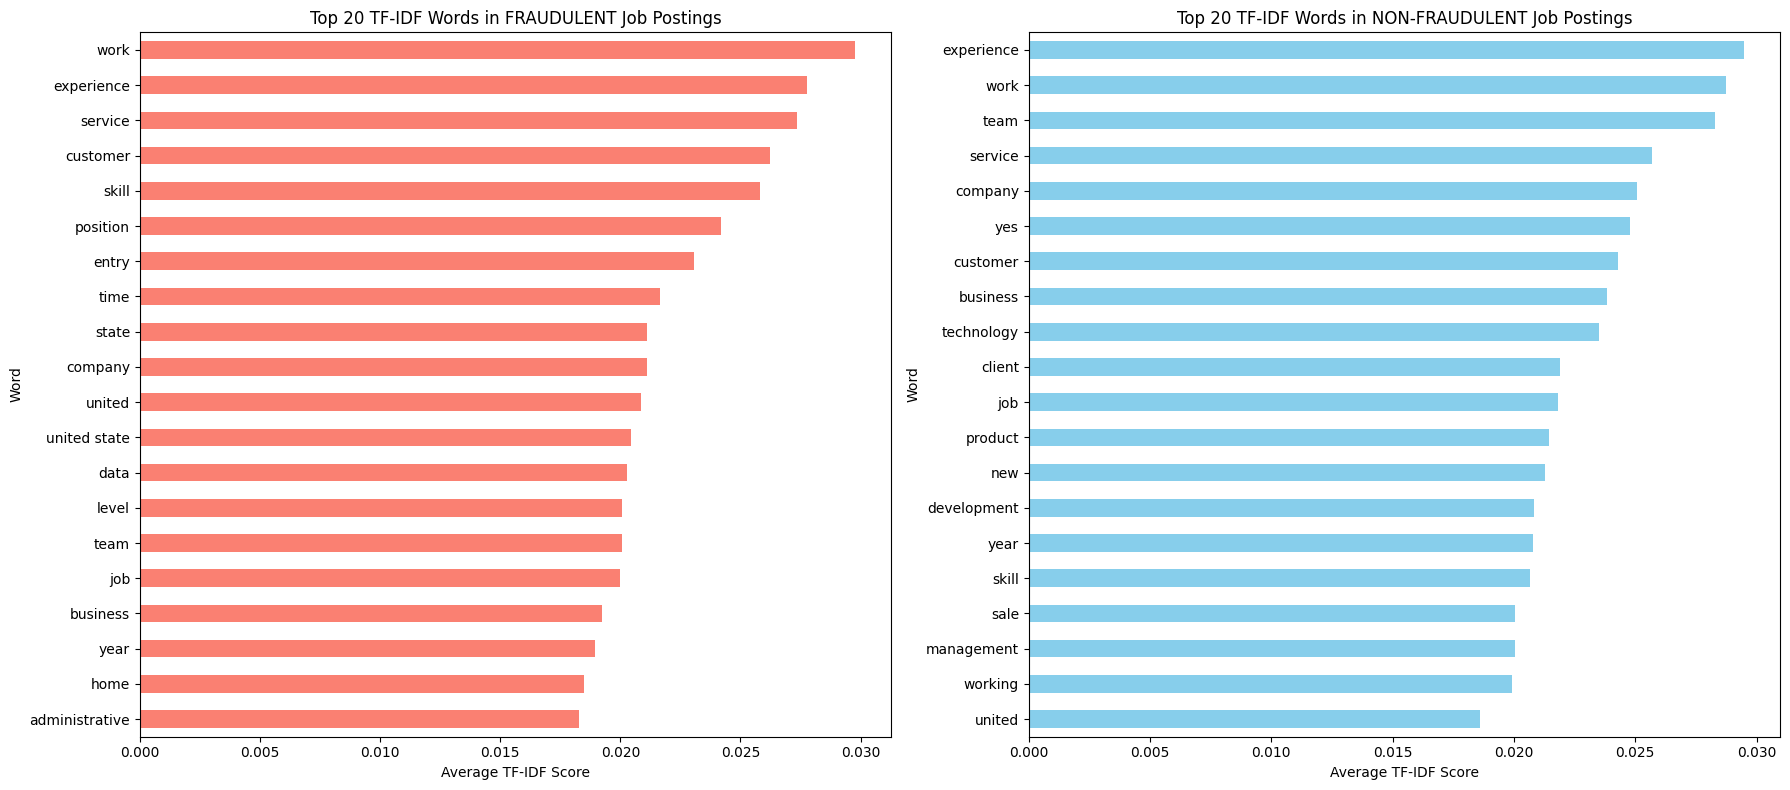

In [43]:
# Vectorize the test set using the already fitted vectorizer
X_test_vectorized = vectorizer.transform(X_test['cleaned_text'])

# Combine the vectorized training and test sets, and keep the corresponding cleaned_text and fraudulent labels
X_combined_vectorized = scipy.sparse.vstack([X_train_vectorized, X_test_vectorized])
y_combined = pd.concat([y_train, y_test])
cleaned_text_combined = pd.concat([X_train['cleaned_text'], X_test['cleaned_text']])

# Create a new DataFrame containing cleaned_text and fraudulent label
combined_df = pd.DataFrame({'cleaned_text': cleaned_text_combined, 'fraudulent': y_combined})
combined_df.reset_index(drop=True, inplace=True)

# Separate fraud and non-fraud texts
fraud_texts = combined_df[combined_df['fraudulent'] == 1]['cleaned_text']
non_fraud_texts = combined_df[combined_df['fraudulent'] == 0]['cleaned_text']

print(f"Number of fraud texts: {len(fraud_texts)}")
print(f"Number of non-fraud texts: {len(non_fraud_texts)}")

# Vectorize fraud texts separately
vectorizer_fraud = TfidfVectorizer(
    max_features=5000,      # Limit to top 2000 features
    ngram_range=(1,2),      # Use unigrams and bigrams
    min_df=2,               # Ignore words that appear in fewer than 2 documents
    stop_words='english',   # Remove English stopwords
    sublinear_tf=True       # Apply sublinear term frequency scaling
)
X_fraud_vectorized = vectorizer_fraud.fit_transform(fraud_texts)

# Vectorize non-fraud texts separately
vectorizer_non_fraud = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2,
    stop_words='english',
    sublinear_tf=True
)
X_non_fraud_vectorized = vectorizer_non_fraud.fit_transform(non_fraud_texts)

# Compute average TF-IDF scores for fraud texts
mean_tfidf_fraud = X_fraud_vectorized.mean(axis=0)
tfidf_scores_fraud = pd.Series(
    np.array(mean_tfidf_fraud).flatten(),
    index=vectorizer_fraud.get_feature_names_out()
)
tfidf_scores_fraud = tfidf_scores_fraud.sort_values(ascending=False)

# Compute average TF-IDF scores for non-fraud texts
mean_tfidf_non_fraud = X_non_fraud_vectorized.mean(axis=0)
tfidf_scores_non_fraud = pd.Series(
    np.array(mean_tfidf_non_fraud).flatten(),
    index=vectorizer_non_fraud.get_feature_names_out()
)
tfidf_scores_non_fraud = tfidf_scores_non_fraud.sort_values(ascending=False)

# Remove any tokens that contain 'unknown'
tfidf_scores_fraud = tfidf_scores_fraud[~tfidf_scores_fraud.index.str.contains("unknown")]
tfidf_scores_non_fraud = tfidf_scores_non_fraud[~tfidf_scores_non_fraud.index.str.contains("unknown")]


# Print top 20 TF-IDF words for each category
print("\nTop 20 TF-IDF words in FRAUDULENT job postings:")
print(tfidf_scores_fraud.head(20))

print("\nTop 20 TF-IDF words in NON-FRAUDULENT job postings:")
print(tfidf_scores_non_fraud.head(20))

# Visualize top 20 TF-IDF words side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top TF-IDF words in fraudulent job postings
tfidf_scores_fraud.head(20).plot(kind='barh', color='salmon', ax=axes[0])
axes[0].invert_yaxis()  # Highest TF-IDF at the top
axes[0].set_title("Top 20 TF-IDF Words in FRAUDULENT Job Postings")
axes[0].set_xlabel("Average TF-IDF Score")
axes[0].set_ylabel("Word")

# Top TF-IDF words in non-fraudulent job postings
tfidf_scores_non_fraud.head(20).plot(kind='barh', color='skyblue', ax=axes[1])
axes[1].invert_yaxis()
axes[1].set_title("Top 20 TF-IDF Words in NON-FRAUDULENT Job Postings")
axes[1].set_xlabel("Average TF-IDF Score")
axes[1].set_ylabel("Word")

plt.tight_layout()
plt.show()

Wordcloud

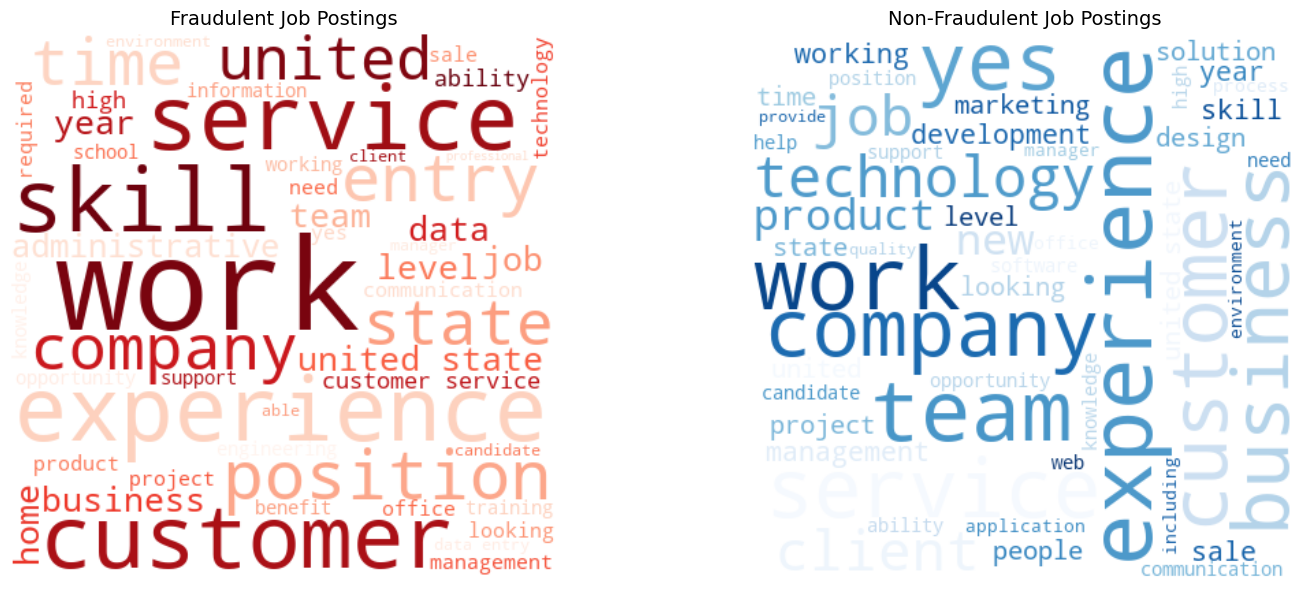

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get top 50 words for each category
fraud_top50 = tfidf_scores_fraud.head(50)
non_fraud_top50 = tfidf_scores_non_fraud.head(50)

# Create WordClouds
wordcloud_fraud = WordCloud(width=400, height=400, background_color='white', colormap='Reds').generate_from_frequencies(fraud_top50)
wordcloud_non_fraud = WordCloud(width=400, height=400, background_color='white', colormap='Blues').generate_from_frequencies(non_fraud_top50)

# Plot side by side in the same row
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(wordcloud_fraud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Fraudulent Job Postings", fontsize=14)

axes[1].imshow(wordcloud_non_fraud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Non-Fraudulent Job Postings", fontsize=14)

plt.tight_layout()
plt.show()


Start training
- use the cleaned_text that have already tf-idf to train

In [45]:
classifiers = get_classifiers()
model_dir = "models_notebook"

In [46]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: '{model_dir}'")
else:
    print(f"Directory '{model_dir}' already exists.")

training_types = ["original", "undersample", "hybrid"]
print(f"Models will be trained using the following data strategies: {', '.join(training_types)}")
print("--- Starting Model Training ---")

Directory 'models_notebook' already exists.
Models will be trained using the following data strategies: original, undersample, hybrid
--- Starting Model Training ---


In [47]:
# --- Original Training --- 
# dont have apply any sampling technique and handling imbalanced data

X_curr, y_curr = X_train_vectorized.copy(), y_train.copy()

for name, model in classifiers.items():
    print(f"Training {name} on ORIGINAL data...")
    start_time = time.time()
    
    model.fit(X_curr, y_curr)
    elapsed = time.time() - start_time
    print(f"✅ {name} trained in {elapsed:.1f} seconds.")
    
    # Save the trained model
    model_filename = os.path.join(model_dir, f"{name.replace(' ','_').lower()}_original.joblib")
    joblib.dump(model, model_filename)
    print(f"Saved model: {model_filename}")


Training Random Forest on ORIGINAL data...
✅ Random Forest trained in 4.7 seconds.
Saved model: models_notebook\random_forest_original.joblib
Training Naive Bayes on ORIGINAL data...
✅ Naive Bayes trained in 0.0 seconds.
Saved model: models_notebook\naive_bayes_original.joblib
Training Support Vector Machine on ORIGINAL data...
✅ Support Vector Machine trained in 227.9 seconds.
Saved model: models_notebook\support_vector_machine_original.joblib


In [48]:
# --- Hybrid Training ---
sampler = SMOTEENN(random_state=42, n_jobs=-1)
X_hybrid, y_hybrid = sampler.fit_resample(X_train_vectorized, y_train)
print(f"Hybrid counts: 0={y_hybrid.value_counts()[0]}, 1={y_hybrid.value_counts()[1]}")

for name, model in classifiers.items():
    print(f"Training {name} on HYBRID data...")
    start_time = time.time()
    
    # Recreate classifier if needed
    if name == "Random Forest":
        model = RandomForestClassifier(
            n_estimators=300, max_depth=20, min_samples_split=5,
            min_samples_leaf=2, max_features="sqrt",
            class_weight="balanced", random_state=42, n_jobs=-1
        )
    elif name == "Naive Bayes":
        model = MultinomialNB()
    elif name == "Support Vector Machine":
        model = SVC(probability=True, random_state=42)
    
    model.fit(X_hybrid, y_hybrid)
    elapsed = time.time() - start_time
    print(f"✅ {name} trained in {elapsed:.1f} seconds.")
    
    # Save the trained model
    model_filename = os.path.join(model_dir, f"{name.replace(' ','_').lower()}_hybrid.joblib")
    joblib.dump(model, model_filename)
    print(f"Saved model: {model_filename}")


Hybrid counts: 0=8388, 1=11910
Training Random Forest on HYBRID data...
✅ Random Forest trained in 12.7 seconds.
Saved model: models_notebook\random_forest_hybrid.joblib
Training Naive Bayes on HYBRID data...
✅ Naive Bayes trained in 0.0 seconds.
Saved model: models_notebook\naive_bayes_hybrid.joblib
Training Support Vector Machine on HYBRID data...
✅ Support Vector Machine trained in 420.5 seconds.
Saved model: models_notebook\support_vector_machine_hybrid.joblib


In [49]:
joblib.dump(vectorizer, os.path.join(model_dir, "vectorizer.joblib"))

['models_notebook\\vectorizer.joblib']

In [50]:
data.to_csv('cleaned_data.csv', index=False) #for evaluate notebook to load this csv file